In [179]:
import numpy as np
from scipy import stats, sparse
import json
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from IPython.display import clear_output
from datetime import datetime
import imageio
import time
import gc
import os

from tqdm import tqdm
import networkx as nx

In [3]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

Graph density = 0.5987987987987987 %.
(1000, 1000)
[0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 

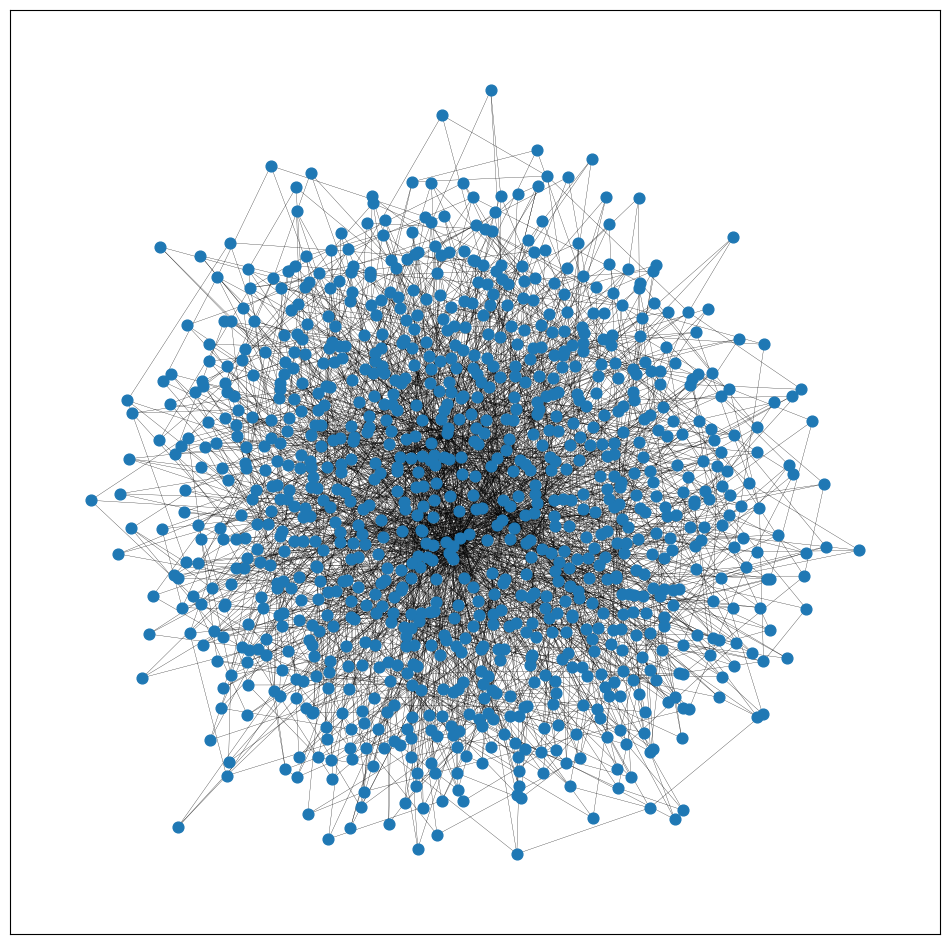

In [4]:
# N agents
N = 1000

# m possible opinion values 
m = 3

# Maximum global time T
T = 100 * N

# Social network G (static by default), adjacency matrix
# d number of edges to attach from a new node to existing nodes
d = 3
seed = 42
Gr = nx.barabasi_albert_graph(N, d, seed=seed)

G = nx.to_scipy_sparse_array(Gr)

print("Graph density = {} %.".format(nx.density(Gr) * 100))
print(G.todense().shape)
print(G.todense()[0])
#nx.draw_networkx(Gr, pos=nx.spring_layout(Gr, seed=42, k=1))
plt.figure(figsize=(12,12))
nx.draw_networkx(Gr, node_size=60,font_size=5, width=0.2, pos=nx.spring_layout(Gr, seed=42), with_labels=False)

plt.show()


In [ ]:
N = 10
d = 3

Gr1 = nx.barabasi_albert_graph(N, d)

G1 = nx.to_scipy_sparse_array(Gr1)

Gr2 = nx.barabasi_albert_graph(N, d)

G2 = nx.to_scipy_sparse_array(Gr2)

print(G1.todense() == G2.todense())

[[ True  True  True  True False False  True  True  True  True]
 [ True  True  True  True  True False  True False  True False]
 [ True  True  True  True False False  True False False False]
 [ True  True  True  True  True  True  True  True  True  True]
 [False  True False  True  True False False  True  True  True]
 [False False False  True False  True False False  True False]
 [ True  True  True  True False False  True False  True  True]
 [ True False False  True  True False False  True False False]
 [ True  True False  True  True  True  True False  True  True]
 [ True False False  True  True False  True False  True  True]]


In [5]:
# Transition matrix
P = np.zeros((3, 3, 3))

# Use this P matrix
P[0] = np.array([[0.96, 0.04, 0.0], [0.942, 0.057, 0.001], [0.907, 0.091, 0.002]])

#P[1] = np.array([[0.039, 0.952, 0.008], [0.021, 0.969, 0.01], [0.02, 0.944, 0.036]])
# Fix stochasticity
P[1] = np.array([[0.039, 0.953, 0.008], [0.021, 0.969, 0.01], [0.02, 0.944, 0.036]])

P[2] = np.array([[0.001, 0.082, 0.917], [0.001, 0.07, 0.929], [0.001, 0.054, 0.945]])

In [6]:
#Check : row stochasticity
for i in range(len(P)): 
    print(np.sum(P[i], axis=1))

[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]


In [96]:
"""
P[0] = np.array([[0.9, 0.1, 0.0], [0.855, 0.143, 0.002], [0.768, 0.228, 0.004]])
P[1] = np.array([[0.024, 0.971, 0.005], [0.013, 0.981, 0.006],[0.012, 0.966, 0.022]])
P[2] = np.array([[0.001, 0.064, 0.935], [0.001, 0.054, 0.945], [0.001, 0.042, 0.957]])
"""

In [97]:
"""
#Check : row stochasticity
for i in range(len(P)): 
    print(np.sum(P[i], axis=1))
"""

[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]


In [7]:
# MODEL LOG
# Opinion trajectories : o[t][i] in X = {x1, x2, .., xm}, t = [0, T-1], i = [O, N-1]
o = np.zeros((T+1, N), dtype=int)


# Initialize random opinion vector
o[0] = np.random.choice(m, N)

# CHANGE here for initial opinion distribution
# o[0] = ...

# Populations of camps : Y[t][k] in [0, N]
Y = np.zeros((T+1, m), dtype=int)
_, Y[0] = np.unique(o[0], return_counts=True)

influences = []

In [8]:
# Setting node colors to represent initial opinions
node_colors = ["tab:blue" if opinion==0 else "tab:grey" if opinion==1 else "tab:red" for opinion in o[0]]

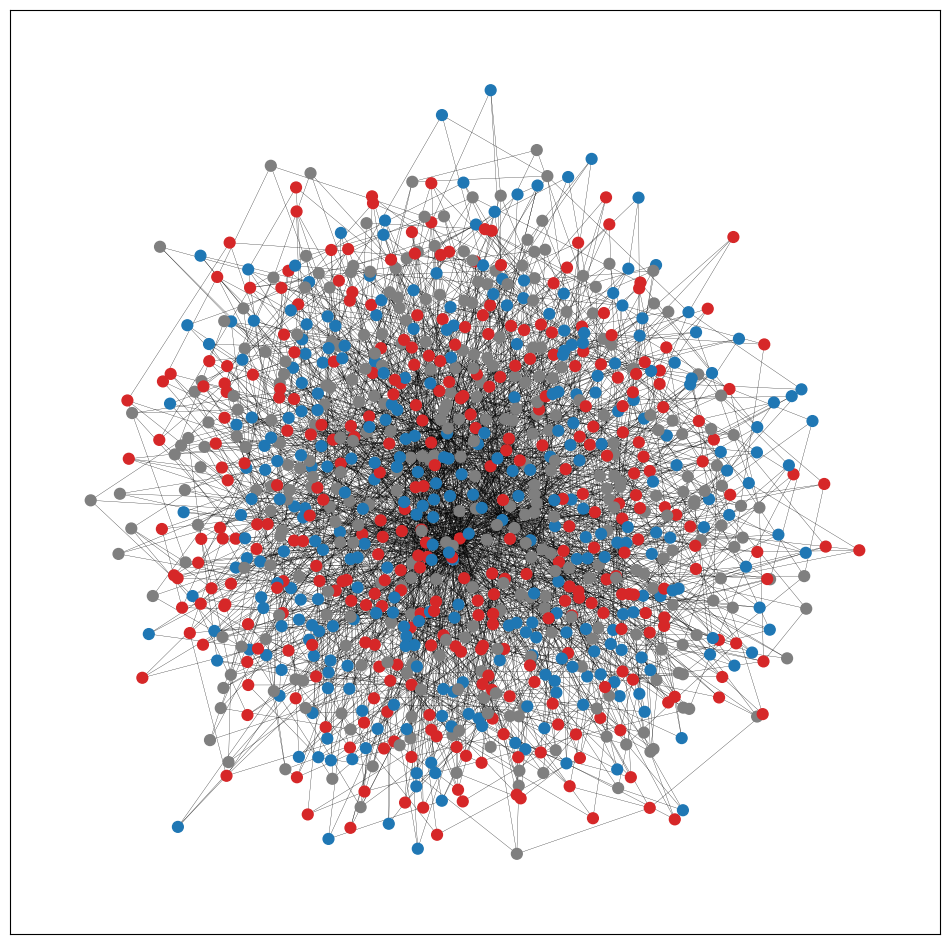

In [9]:
plt.figure(figsize=(12,12))

#fixed layout seed - fixed graph drawing
pos=nx.spring_layout(Gr, seed=42)

nx.draw_networkx(Gr, node_size=60, node_color=node_colors,font_size=5, width=0.2, pos=pos, with_labels=False)
plt.show()

In [30]:
degs = [val for (node, val) in Gr.degree()]

#Assigning m'th opinion to nodes with higher centrality : the node with degree d will have param * (d-mean) times more chance to be of the opinion m than of the others
mean_deg = np.mean(degs)

param = 100

node_probas = []

for deg in degs:
    if deg >= mean_deg:
        p = [1 / (1 + param * (deg - mean_deg)) / (m - 1)]*(m-1)
        p.append(param * (deg - mean_deg) / (1 + param * (deg - mean_deg)))
        node_probas.append(p)
    else:
        node_probas.append([1 / m ]*m)

print(len(node_probas))
print(node_probas[0])
print(param * (degs[0]- mean_deg) * (node_probas[0][0] + node_probas[0][1]) / node_probas[0][2])

1000
[0.0001086295298513948, 0.0001086295298513948, 0.9997827409402972]
1.0


In [33]:
def init_degree_centrality_opinions(N, Gr, m, param):

    if param < 1:
        raise Exception("Initial degree centrality opinions: parameter should be >=1") 

    o_init = np.zeros(N, dtype=int)

    #Graph degrees
    degs = [val for (node, val) in Gr.degree()]

    #Assigning m'th opinion to nodes with higher centrality : the node with degree d will have param * (d-mean) times more chance to be of the opinion m than of the others
    mean_deg = np.mean(degs)

    #Creating proba arrays for np.random.choice
    node_probas = []

    for deg in degs:
        if deg >= mean_deg:
            p = [1 / (1 + param * (deg - mean_deg)) / (m - 1)]*(m-1)
            p.append(param * (deg - mean_deg) / (1 + param * (deg - mean_deg)))
            node_probas.append(p)
        else:
            node_probas.append([1 / m ]*m)

    for i in range(N):
        o_init[i] = np.random.choice(m, p=node_probas[i])

    return o_init

In [35]:
def model(T, N, Gr, G, m, P, o, Y, influences, verbose=False, plot=False): #nodes colors are for m = 3
    # Node positions if plot=True
    if plot:
        pos = nx.spring_layout(Gr, seed=42)
    # Run model
    for t in tqdm(range(T)):
        # Draw graph at the begging of the time step if plot=True
        if (plot==True) & (t % 25000 == 0):
            clear_output(wait=True)
            node_colors = ["tab:blue" if opinion==0 else "tab:grey" if opinion==1 else "tab:red" for opinion in o[t]]
            plt.figure(figsize=(12,12))
            nx.draw_networkx(Gr, node_size=60, node_color=node_colors, font_size=5, width=0.2, pos=pos, with_labels=False)
            plt.show()

        # Random agent i
        # CHECK here randomness while modeling : keep the seed or change it between runs
        agent = np.random.choice(N)
        agent_opinion = o[t][agent]

        # ver1
        # neighbors = np.nonzero(np.array(G.todense()[agent])[0])[0]
        # Faster ver2
        neighbors = G.indices[G.indptr[agent]:G.indptr[agent+1]]

        # Random agent j        
        # CHECK here randomness while modeling : keep the seed or change it between runs
        neighbor = np.random.choice(neighbors)
        neighbor_opinion = o[t][neighbor]

        # Influence 
        # CHECK here randomness while modeling : keep the seed or change it between runs
        new_agent_op = np.random.choice(m, p=P[agent_opinion][neighbor_opinion])

        # Model log for the beging of the next time step
        # Copying
        o[t+1] = o[t].copy()
        Y[t+1] = Y[t].copy()
        # Influence during the time step t
        o[t+1][agent] = new_agent_op
        Y[t+1][agent_opinion] -= 1
        Y[t+1][new_agent_op] += 1

        infl = (agent, agent_opinion, neighbor, neighbor_opinion, new_agent_op)
        influences.append(infl)

        if verbose:
            print("At time step {}: {}.".format(t, infl))

In [185]:
def run_and_save_experiment(exp_name, m, P, param, series, T, plot=False, **graph_params):
    N = graph_params["N"]

    #hyperparams save
    hps_dict = {"name" : exp_name, #use graph model name
               "graph_params" : graph_params,
               "opinions" : m,
               "transition_matrix" : P.tolist(),
               "param values" : [param],
               "number of runs" : series
               }
    
    if not os.path.exists("./" + exp_name):
        os.makedirs("./" + exp_name)

    if not os.path.exists("./" + exp_name + "/param=" + str(param)):
        os.makedirs("./" + exp_name + "/param=" + str(param))
    else:
        raise Exception("Experiement with a such paramerter already exists.")

    # that's a new param
    if os.path.exists("./" + exp_name + "/hyperparams.json"):
        with open("./" + exp_name + "/hyperparams.json", "r") as logHps:
            hps_dict = json.load(logHps)
        
        hps_dict["param values"].append(param)
        
        #Overwrite hyperparameters dict
        os.remove("./" + exp_name + "/hyperparams.json")
        with open("./" + exp_name + "/hyperparams.json", "w") as logHps:
            json.dump(hps_dict, logHps)
    else: #first param in experiment
        with open("./" + exp_name + "/hyperparams.json", "w") as logHps:
            json.dump(hps_dict, logHps)


    for i in range(series):
        # Random init of graph
        Gr = nx.barabasi_albert_graph(N, d)
        G = nx.to_scipy_sparse_array(Gr)

        # Save sparse graph adjacency matrix in compressed
        sparse.save_npz("./" + exp_name + "/param=" + str(param) + "/" + exp_name + " " + str(param) + " " + str(i) + ".npz", G)

        T_run = T

        # Model log
        # Opinion trajectories : o[t][i] in X = {x1, x2, .., xm}, t = [0, T-1], i = [O, N-1]
        o_run = np.zeros((T_run+1, N), dtype=int)

        # Initialize opinion vector
        # CHECK here randomness while modeling : keep the seed or change it between runs

        # ver1
        # o_run[0] = np.random.choice(m, N)
        # ver2
        o_run[0] = init_degree_centrality_opinions(N, Gr, m, param)

        # Populations of camps : Y[t][k] in [0, N]
        Y_run = np.zeros((T_run+1, m), dtype=int)
        _, Y_run[0] = np.unique(o_run[0], return_counts=True)

        infls_run = []

        # Print init populations
        print(Y_run[0])

        # Run model
        model(T_run, N, Gr, G, m, P, o_run, Y_run, infls_run, plot=plot)

        Y_run_to_json = getattr(Y_run, "tolist", lambda: Y_run)()

        now = datetime.now()
        exp_datetime = now.strftime("%d%m%Y %H:%M")

        run_dict = {"experient name" : exp_name, #use graph model name
                    "datetime" : exp_datetime,
                    "param" : param,
                    "run number" : i,
                    "inintial opinions" : o_run[0].tolist(),
                    "influences" : infls_run,
                    "Y distribution" : Y_run_to_json
                    }

        with open("./" + exp_name + "/param=" + str(param) + "/run=" + str(i) +".json", "w") as logExpRun:
            json.dump(run_dict, logExpRun, cls=NpEncoder)


In [103]:
def load_experiment(exp_name, param, run_number): #run number starts from 0
    if os.path.exists("./" + exp_name + "/hyperparams.json"):
        with open("./" + exp_name + "/hyperparams.json", "r") as logHps:
            hps_dict = json.load(logHps)
    else:
        try:
            raise TypeError(exp_name)
        except Exception as e1:
            print("Exception: No experiment with the name \"{}\".".format( e1 ))

    run_dict = {}
    if param in set(hps_dict["param values"]):
        with open("./" + exp_name + "/param=" + str(param) + "/run=" + str(run_number) +".json", "r") as logExpRun:
            run_dict  = json.load(logExpRun)
    else:
        try:
            raise TypeError("(" + exp_name + "," + str(param) + ")")
        except Exception as e2:
            print("Exception: There is no couple (exp_name, param) {}.".format( e2 ) )

    return hps_dict, run_dict

In [105]:
# No experiment name
hps_dict, run_dict = load_experiment("second law of thermodynamics disproof", param=1, run_number=0)
hps_dict, run_dict

Exception: No experiment with the name "second law of thermodynamics disproof".


UnboundLocalError: local variable 'hps_dict' referenced before assignment

In [106]:
# No param in experiment
hps_dict, run_dict = load_experiment("test init degree centrality opinions", param=-1, run_number=0)
hps_dict, run_dict

Exception: There is no couple (exp_name, param) (test init degree centrality opinions,-1).


({'name': 'test init degree centrality opinions',
  'graph_params': {'N': 1000, 'd': 3, 'seed': 42},
  'opinions': 3,
  'transition_matrix': [[[0.96, 0.04, 0.0],
    [0.942, 0.057, 0.001],
    [0.907, 0.091, 0.002]],
   [[0.039, 0.953, 0.008], [0.021, 0.969, 0.01], [0.02, 0.944, 0.036]],
   [[0.001, 0.082, 0.917], [0.001, 0.07, 0.929], [0.001, 0.054, 0.945]]],
  'param values': [5, 1],
  'number of runs': 2},
 {})

### Run experiments
for random Barabasi-Albert graphs on N = 1000, d = 3, and m = 3 opinions; with initial opinion distribution parameters params = [1, 5, 10, 25, 50, 100], number of runs  = 30

In [197]:
N = 1000
d = 3

m = 3

params = [1, 5, 10, 50, 100, 1000]

series = 30

for param in params:
    run_and_save_experiment("Barabasi-Albert : N = 1000, d = 3, m = 3 (v2)", m, P, param, series, T=500*N, N=N, d=d)

[310 296 394]


100%|██████████| 500000/500000 [00:31<00:00, 15966.13it/s]


[313 287 400]


100%|██████████| 500000/500000 [00:31<00:00, 16016.61it/s]


[279 319 402]


100%|██████████| 500000/500000 [00:32<00:00, 15584.28it/s]


[292 303 405]


100%|██████████| 500000/500000 [00:31<00:00, 15786.92it/s]


[311 290 399]


100%|██████████| 500000/500000 [00:30<00:00, 16279.76it/s]


[312 293 395]


100%|██████████| 500000/500000 [00:31<00:00, 15784.50it/s]


[277 313 410]


100%|██████████| 500000/500000 [00:31<00:00, 16119.02it/s]


[273 324 403]


100%|██████████| 500000/500000 [00:30<00:00, 16494.42it/s]


[306 284 410]


100%|██████████| 500000/500000 [00:30<00:00, 16344.95it/s]


[316 293 391]


100%|██████████| 500000/500000 [00:31<00:00, 15908.72it/s]


[296 317 387]


100%|██████████| 500000/500000 [00:31<00:00, 15857.92it/s]


[303 320 377]


100%|██████████| 500000/500000 [00:31<00:00, 15963.17it/s]


[288 298 414]


100%|██████████| 500000/500000 [00:31<00:00, 15772.23it/s]


[302 321 377]


100%|██████████| 500000/500000 [00:31<00:00, 15855.81it/s]


[289 308 403]


100%|██████████| 500000/500000 [00:31<00:00, 16043.22it/s]


[321 304 375]


100%|██████████| 500000/500000 [00:30<00:00, 16257.32it/s]


[260 314 426]


100%|██████████| 500000/500000 [00:31<00:00, 15847.99it/s]


[295 320 385]


100%|██████████| 500000/500000 [00:32<00:00, 15555.27it/s]


[318 312 370]


100%|██████████| 500000/500000 [00:30<00:00, 16411.08it/s]


[277 314 409]


100%|██████████| 500000/500000 [00:30<00:00, 16503.09it/s]


[337 279 384]


100%|██████████| 500000/500000 [00:31<00:00, 16055.47it/s]


[293 322 385]


100%|██████████| 500000/500000 [00:31<00:00, 15635.96it/s]


[301 287 412]


100%|██████████| 500000/500000 [00:31<00:00, 15966.68it/s]


[298 298 404]


100%|██████████| 500000/500000 [00:32<00:00, 15565.21it/s]


[293 291 416]


100%|██████████| 500000/500000 [00:31<00:00, 15953.23it/s]


[302 307 391]


100%|██████████| 500000/500000 [00:30<00:00, 16455.95it/s]


[320 286 394]


100%|██████████| 500000/500000 [00:30<00:00, 16315.05it/s]


[303 271 426]


100%|██████████| 500000/500000 [00:31<00:00, 15821.12it/s]


[332 284 384]


100%|██████████| 500000/500000 [00:31<00:00, 16088.29it/s]


[283 323 394]


100%|██████████| 500000/500000 [00:30<00:00, 16625.92it/s]


[281 288 431]


100%|██████████| 500000/500000 [00:30<00:00, 16329.99it/s]


[271 286 443]


100%|██████████| 500000/500000 [00:30<00:00, 16312.20it/s]


[287 280 433]


100%|██████████| 500000/500000 [00:30<00:00, 16573.60it/s]


[286 287 427]


100%|██████████| 500000/500000 [00:30<00:00, 16337.11it/s]


[268 284 448]


100%|██████████| 500000/500000 [00:30<00:00, 16542.72it/s]


[284 283 433]


100%|██████████| 500000/500000 [00:30<00:00, 16563.01it/s]


[286 258 456]


100%|██████████| 500000/500000 [00:30<00:00, 16321.75it/s]


[263 291 446]


100%|██████████| 500000/500000 [00:30<00:00, 16436.48it/s]


[284 291 425]


100%|██████████| 500000/500000 [00:30<00:00, 16538.07it/s]


[276 294 430]


100%|██████████| 500000/500000 [00:31<00:00, 15765.74it/s]


[240 300 460]


100%|██████████| 500000/500000 [00:31<00:00, 16008.87it/s]


[275 265 460]


100%|██████████| 500000/500000 [00:31<00:00, 15964.20it/s]


[268 279 453]


100%|██████████| 500000/500000 [00:31<00:00, 16118.58it/s]


[292 268 440]


100%|██████████| 500000/500000 [00:30<00:00, 16455.26it/s]


[271 290 439]


100%|██████████| 500000/500000 [00:30<00:00, 16522.07it/s]


[281 293 426]


100%|██████████| 500000/500000 [00:30<00:00, 16192.42it/s]


[272 295 433]


100%|██████████| 500000/500000 [00:30<00:00, 16527.89it/s]


[312 253 435]


100%|██████████| 500000/500000 [00:30<00:00, 16641.66it/s]


[268 271 461]


100%|██████████| 500000/500000 [00:31<00:00, 15713.21it/s]


[279 300 421]


100%|██████████| 500000/500000 [00:31<00:00, 15811.98it/s]


[289 265 446]


100%|██████████| 500000/500000 [00:30<00:00, 16396.77it/s]


[316 289 395]


100%|██████████| 500000/500000 [00:31<00:00, 15746.45it/s]


[272 295 433]


100%|██████████| 500000/500000 [00:30<00:00, 16266.92it/s]


[284 255 461]


100%|██████████| 500000/500000 [00:31<00:00, 15871.13it/s]


[268 293 439]


100%|██████████| 500000/500000 [00:31<00:00, 15953.78it/s]


[296 260 444]


100%|██████████| 500000/500000 [00:31<00:00, 15986.17it/s]


[275 277 448]


100%|██████████| 500000/500000 [00:31<00:00, 15982.46it/s]


[282 277 441]


100%|██████████| 500000/500000 [00:32<00:00, 15621.49it/s]


[278 291 431]


100%|██████████| 500000/500000 [00:31<00:00, 16018.09it/s]


[267 283 450]


100%|██████████| 500000/500000 [00:30<00:00, 16469.30it/s]


[307 260 433]


100%|██████████| 500000/500000 [00:30<00:00, 16324.06it/s]


[280 246 474]


100%|██████████| 500000/500000 [00:30<00:00, 16471.50it/s]


[266 270 464]


100%|██████████| 500000/500000 [00:30<00:00, 16444.81it/s]


[276 270 454]


100%|██████████| 500000/500000 [00:30<00:00, 16461.35it/s]


[261 281 458]


100%|██████████| 500000/500000 [00:30<00:00, 16294.17it/s]


[281 292 427]


100%|██████████| 500000/500000 [00:30<00:00, 16220.07it/s]


[272 273 455]


100%|██████████| 500000/500000 [00:30<00:00, 16361.35it/s]


[259 268 473]


100%|██████████| 500000/500000 [00:30<00:00, 16275.60it/s]


[248 298 454]


100%|██████████| 500000/500000 [00:30<00:00, 16569.67it/s]


[262 278 460]


100%|██████████| 500000/500000 [00:30<00:00, 16469.87it/s]


[259 292 449]


100%|██████████| 500000/500000 [00:31<00:00, 15856.22it/s]


[262 272 466]


100%|██████████| 500000/500000 [00:31<00:00, 15863.08it/s]


[276 284 440]


100%|██████████| 500000/500000 [00:31<00:00, 15954.54it/s]


[250 300 450]


100%|██████████| 500000/500000 [00:31<00:00, 15748.59it/s]


[262 262 476]


100%|██████████| 500000/500000 [00:30<00:00, 16421.11it/s]


[248 284 468]


100%|██████████| 500000/500000 [00:31<00:00, 15722.37it/s]


[243 263 494]


100%|██████████| 500000/500000 [00:31<00:00, 15740.84it/s]


[251 258 491]


100%|██████████| 500000/500000 [00:31<00:00, 15892.45it/s]


[265 260 475]


100%|██████████| 500000/500000 [00:31<00:00, 15862.80it/s]


[268 277 455]


100%|██████████| 500000/500000 [00:31<00:00, 15705.52it/s]


[277 246 477]


100%|██████████| 500000/500000 [00:30<00:00, 16460.61it/s]


[278 262 460]


100%|██████████| 500000/500000 [00:30<00:00, 16246.79it/s]


[276 274 450]


100%|██████████| 500000/500000 [00:31<00:00, 16103.26it/s]


[273 255 472]


100%|██████████| 500000/500000 [00:31<00:00, 15770.74it/s]


[283 272 445]


100%|██████████| 500000/500000 [00:30<00:00, 16324.33it/s]


[281 282 437]


100%|██████████| 500000/500000 [00:30<00:00, 16292.39it/s]


[275 274 451]


100%|██████████| 500000/500000 [00:30<00:00, 16180.84it/s]


[276 264 460]


100%|██████████| 500000/500000 [00:31<00:00, 15921.68it/s]


[267 284 449]


100%|██████████| 500000/500000 [00:31<00:00, 15751.07it/s]


[267 274 459]


100%|██████████| 500000/500000 [00:31<00:00, 15877.42it/s]


[258 273 469]


100%|██████████| 500000/500000 [00:31<00:00, 16022.57it/s]


[280 256 464]


100%|██████████| 500000/500000 [00:30<00:00, 16307.58it/s]


[254 282 464]


100%|██████████| 500000/500000 [00:30<00:00, 16191.38it/s]


[253 275 472]


100%|██████████| 500000/500000 [00:31<00:00, 15642.39it/s]


[252 260 488]


100%|██████████| 500000/500000 [00:31<00:00, 15871.13it/s]


[264 238 498]


100%|██████████| 500000/500000 [00:31<00:00, 15858.31it/s]


[250 250 500]


100%|██████████| 500000/500000 [00:31<00:00, 15895.45it/s]


[269 253 478]


100%|██████████| 500000/500000 [00:31<00:00, 16071.12it/s]


[240 264 496]


100%|██████████| 500000/500000 [00:31<00:00, 15678.79it/s]


[260 251 489]


100%|██████████| 500000/500000 [00:32<00:00, 15531.30it/s]


[262 241 497]


100%|██████████| 500000/500000 [00:30<00:00, 16487.58it/s]


[283 235 482]


100%|██████████| 500000/500000 [00:31<00:00, 15897.38it/s]


[255 272 473]


100%|██████████| 500000/500000 [00:31<00:00, 15802.94it/s]


[251 266 483]


100%|██████████| 500000/500000 [00:31<00:00, 15929.81it/s]


[251 274 475]


100%|██████████| 500000/500000 [00:31<00:00, 15981.43it/s]


[241 271 488]


100%|██████████| 500000/500000 [00:31<00:00, 15703.47it/s]


[264 247 489]


100%|██████████| 500000/500000 [00:31<00:00, 15873.06it/s]


[254 270 476]


100%|██████████| 500000/500000 [00:31<00:00, 15834.45it/s]


[267 271 462]


100%|██████████| 500000/500000 [00:31<00:00, 15721.97it/s]


[244 275 481]


100%|██████████| 500000/500000 [00:31<00:00, 16048.65it/s]


[261 259 480]


100%|██████████| 500000/500000 [00:30<00:00, 16557.26it/s]


[253 257 490]


100%|██████████| 500000/500000 [00:31<00:00, 15908.83it/s]


[265 264 471]


100%|██████████| 500000/500000 [00:31<00:00, 16067.91it/s]


[281 263 456]


100%|██████████| 500000/500000 [00:31<00:00, 15891.62it/s]


[255 257 488]


100%|██████████| 500000/500000 [00:31<00:00, 15969.27it/s]


[245 246 509]


100%|██████████| 500000/500000 [00:31<00:00, 16109.79it/s]


[285 250 465]


100%|██████████| 500000/500000 [00:31<00:00, 15713.02it/s]


[246 267 487]


100%|██████████| 500000/500000 [00:31<00:00, 15923.92it/s]


[253 260 487]


100%|██████████| 500000/500000 [00:31<00:00, 16053.93it/s]


[229 275 496]


100%|██████████| 500000/500000 [00:30<00:00, 16474.72it/s]


[241 242 517]


100%|██████████| 500000/500000 [00:30<00:00, 16574.17it/s]


[273 234 493]


100%|██████████| 500000/500000 [00:30<00:00, 16482.80it/s]


[267 233 500]


100%|██████████| 500000/500000 [00:30<00:00, 16429.28it/s]


[252 264 484]


100%|██████████| 500000/500000 [00:31<00:00, 15825.05it/s]


[258 229 513]


100%|██████████| 500000/500000 [00:31<00:00, 15642.99it/s]


[245 257 498]


100%|██████████| 500000/500000 [00:32<00:00, 15582.83it/s]


[248 233 519]


100%|██████████| 500000/500000 [00:31<00:00, 16014.42it/s]


[268 239 493]


100%|██████████| 500000/500000 [00:31<00:00, 15841.29it/s]


[239 253 508]


100%|██████████| 500000/500000 [00:30<00:00, 16415.90it/s]


[276 242 482]


100%|██████████| 500000/500000 [00:31<00:00, 15995.73it/s]


[255 240 505]


100%|██████████| 500000/500000 [00:31<00:00, 15856.39it/s]


[230 263 507]


100%|██████████| 500000/500000 [00:31<00:00, 15991.30it/s]


[252 253 495]


100%|██████████| 500000/500000 [00:31<00:00, 16065.69it/s]


[268 242 490]


100%|██████████| 500000/500000 [00:31<00:00, 16010.05it/s]


[247 227 526]


100%|██████████| 500000/500000 [00:31<00:00, 16037.52it/s]


[249 251 500]


100%|██████████| 500000/500000 [00:31<00:00, 15887.28it/s]


[256 232 512]


100%|██████████| 500000/500000 [00:30<00:00, 16251.77it/s]


[241 249 510]


100%|██████████| 500000/500000 [00:30<00:00, 16517.51it/s]


[234 258 508]


100%|██████████| 500000/500000 [00:30<00:00, 16209.70it/s]


[275 247 478]


100%|██████████| 500000/500000 [00:31<00:00, 15728.42it/s]


[265 253 482]


100%|██████████| 500000/500000 [00:30<00:00, 16371.43it/s]


[261 234 505]


100%|██████████| 500000/500000 [00:30<00:00, 16467.99it/s]


[271 225 504]


100%|██████████| 500000/500000 [00:30<00:00, 16252.02it/s]


[260 241 499]


100%|██████████| 500000/500000 [00:30<00:00, 16507.60it/s]


[280 239 481]


100%|██████████| 500000/500000 [00:30<00:00, 16479.07it/s]


[260 245 495]


100%|██████████| 500000/500000 [00:31<00:00, 15998.44it/s]


[229 254 517]


100%|██████████| 500000/500000 [00:31<00:00, 15779.44it/s]


[250 235 515]


100%|██████████| 500000/500000 [00:31<00:00, 16109.33it/s]


[262 241 497]


100%|██████████| 500000/500000 [00:31<00:00, 15736.39it/s]


[236 259 505]


100%|██████████| 500000/500000 [00:31<00:00, 16103.62it/s]


[227 251 522]


100%|██████████| 500000/500000 [00:30<00:00, 16269.55it/s]


[214 255 531]


100%|██████████| 500000/500000 [00:30<00:00, 16301.33it/s]


[261 217 522]


100%|██████████| 500000/500000 [00:30<00:00, 16541.44it/s]


[252 231 517]


100%|██████████| 500000/500000 [00:30<00:00, 16279.89it/s]


[239 237 524]


100%|██████████| 500000/500000 [00:30<00:00, 16547.80it/s]


[231 229 540]


100%|██████████| 500000/500000 [00:30<00:00, 16505.37it/s]


[251 211 538]


100%|██████████| 500000/500000 [00:30<00:00, 16316.18it/s]


[240 231 529]


100%|██████████| 500000/500000 [00:30<00:00, 16328.05it/s]


[243 231 526]


100%|██████████| 500000/500000 [00:31<00:00, 16062.89it/s]


[231 241 528]


100%|██████████| 500000/500000 [00:31<00:00, 15939.58it/s]


[240 251 509]


100%|██████████| 500000/500000 [00:30<00:00, 16556.87it/s]


[232 254 514]


100%|██████████| 500000/500000 [00:30<00:00, 16514.98it/s]


[235 238 527]


100%|██████████| 500000/500000 [00:30<00:00, 16205.97it/s]


[231 238 531]


100%|██████████| 500000/500000 [00:30<00:00, 16153.12it/s]


[264 227 509]


100%|██████████| 500000/500000 [00:31<00:00, 15719.66it/s]


[222 247 531]


100%|██████████| 500000/500000 [00:32<00:00, 15613.36it/s]


[238 252 510]


100%|██████████| 500000/500000 [00:31<00:00, 15939.43it/s]


[252 237 511]


100%|██████████| 500000/500000 [00:30<00:00, 16182.53it/s]


[231 231 538]


100%|██████████| 500000/500000 [00:31<00:00, 15749.48it/s]


[251 226 523]


100%|██████████| 500000/500000 [00:31<00:00, 15862.04it/s]


[222 235 543]


100%|██████████| 500000/500000 [00:30<00:00, 16389.58it/s]


[238 229 533]


100%|██████████| 500000/500000 [00:31<00:00, 15783.58it/s]


[231 254 515]


100%|██████████| 500000/500000 [00:31<00:00, 16006.48it/s]


[227 250 523]


100%|██████████| 500000/500000 [00:31<00:00, 16032.29it/s]


[246 235 519]


100%|██████████| 500000/500000 [00:31<00:00, 15847.60it/s]


[244 239 517]


100%|██████████| 500000/500000 [00:30<00:00, 16190.17it/s]


[246 223 531]


100%|██████████| 500000/500000 [00:30<00:00, 16482.94it/s]


[224 246 530]


100%|██████████| 500000/500000 [00:31<00:00, 16078.91it/s]


[241 229 530]


100%|██████████| 500000/500000 [00:31<00:00, 15757.76it/s]


[233 259 508]


100%|██████████| 500000/500000 [00:31<00:00, 15727.15it/s]


### Calculating statistics at the different times t

In [143]:
hps_dict, _ = load_experiment("Barabasi-Albert : N = 1000, d = 3, m = 3 (v2)", param=1, run_number=0)
N = hps_dict["graph_params"]["N"]
m = hps_dict["opinions"]
params = hps_dict["param values"]
series = hps_dict["number of runs"]

print(params)

[1, 5, 10, 25, 50, 100]


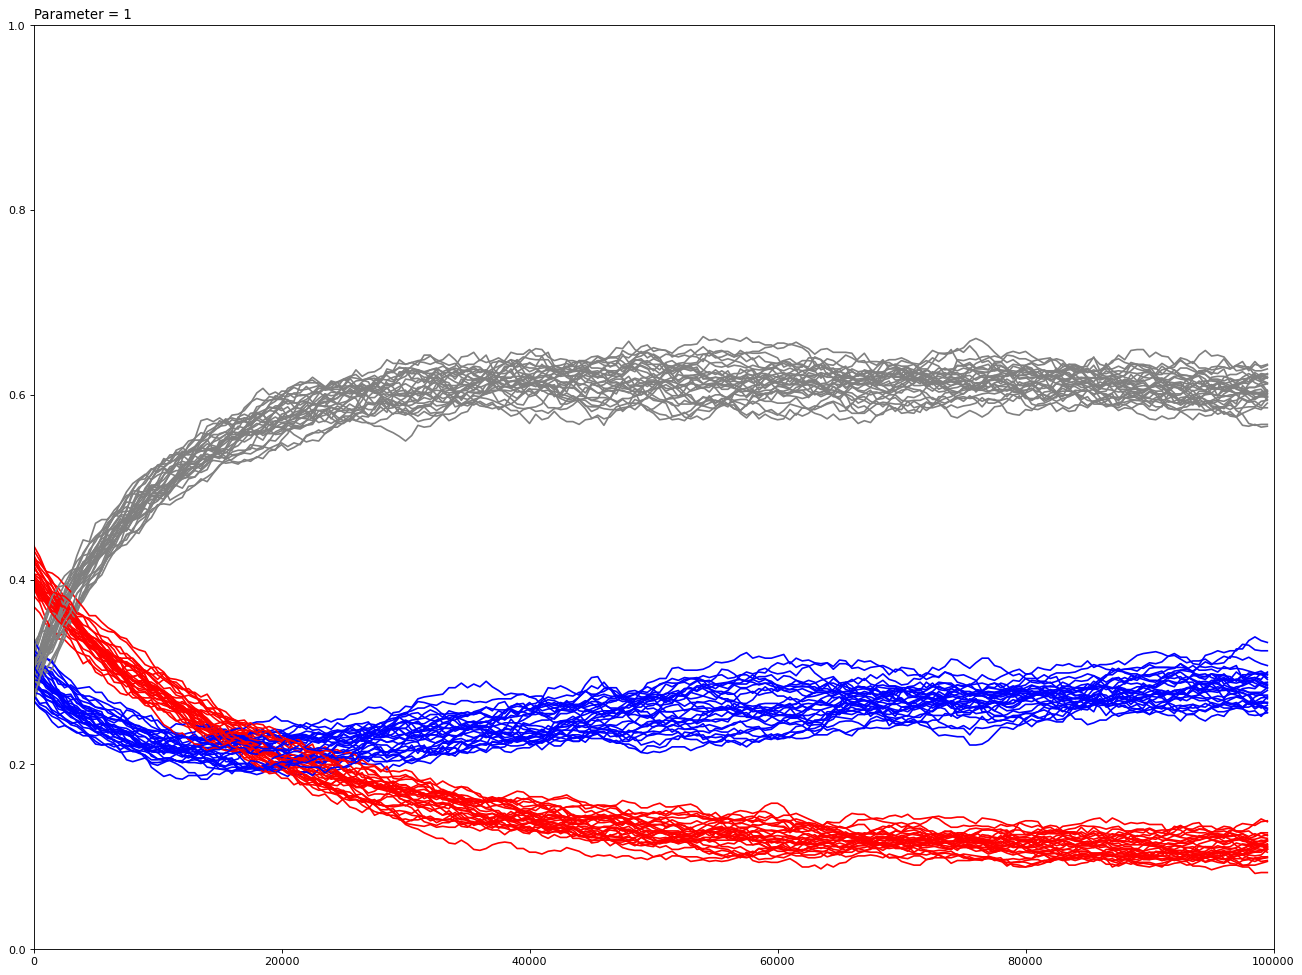

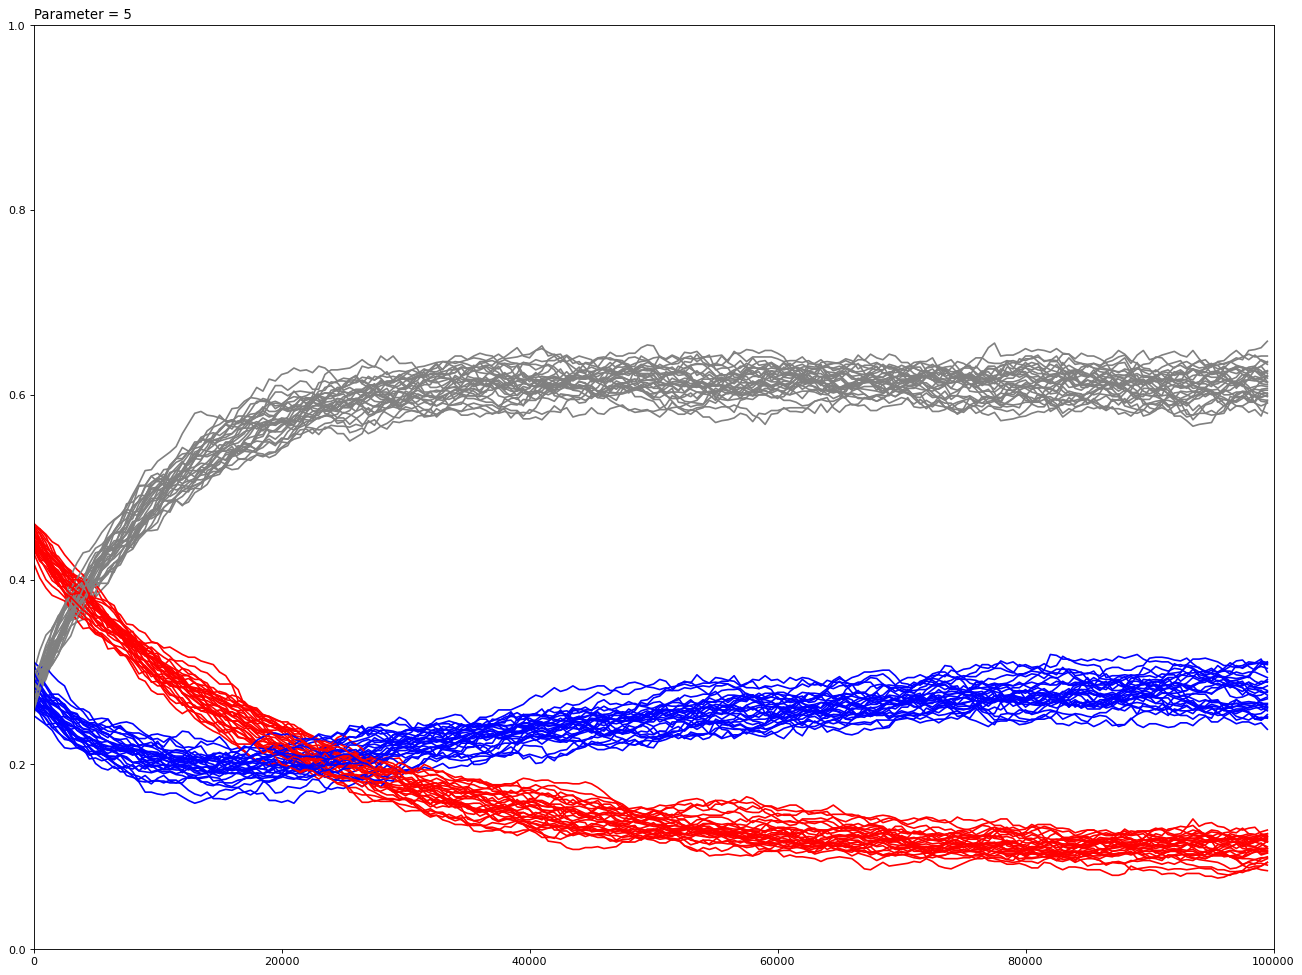

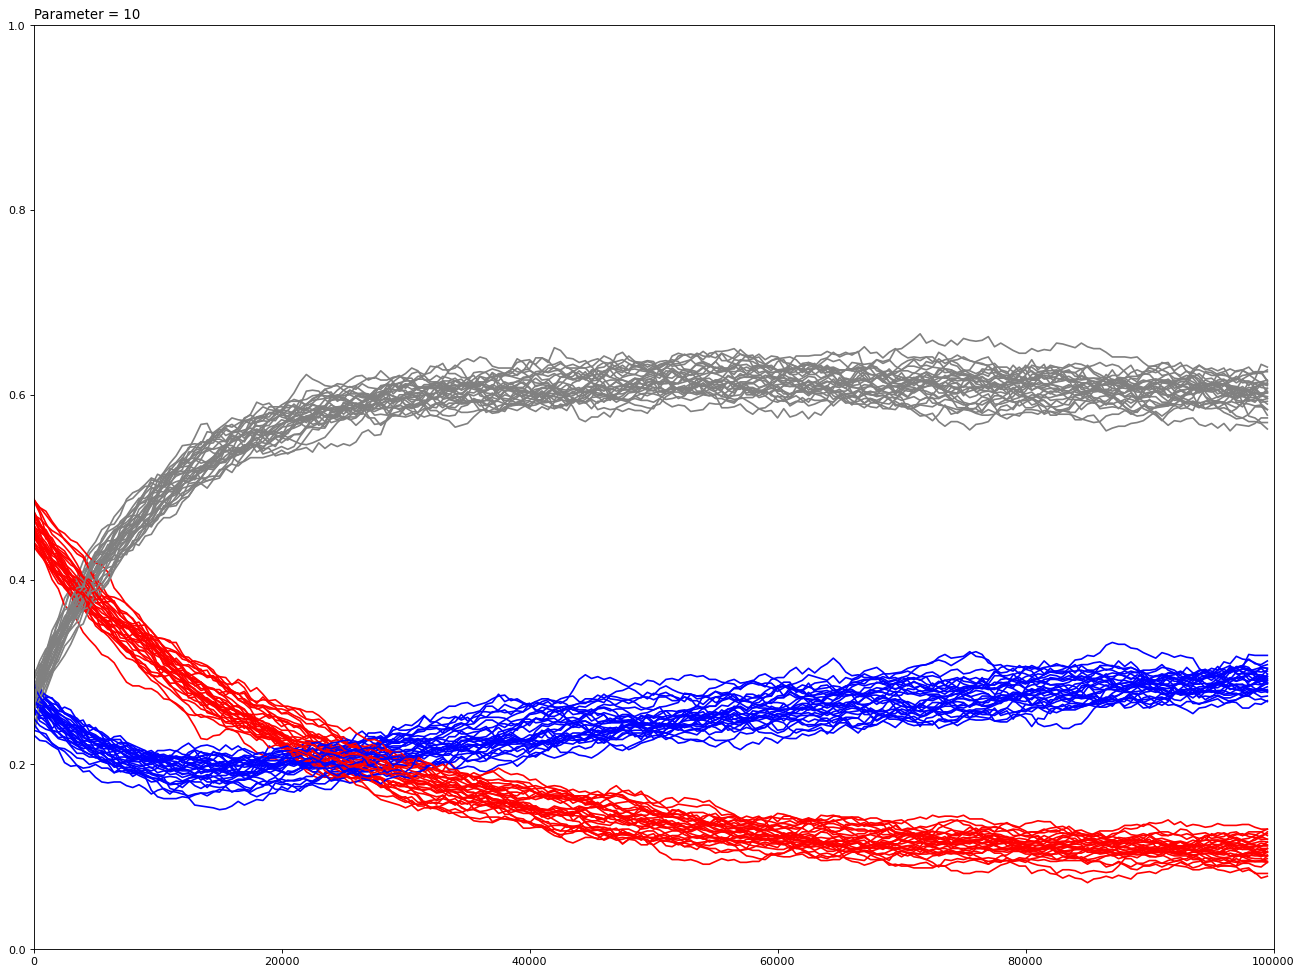

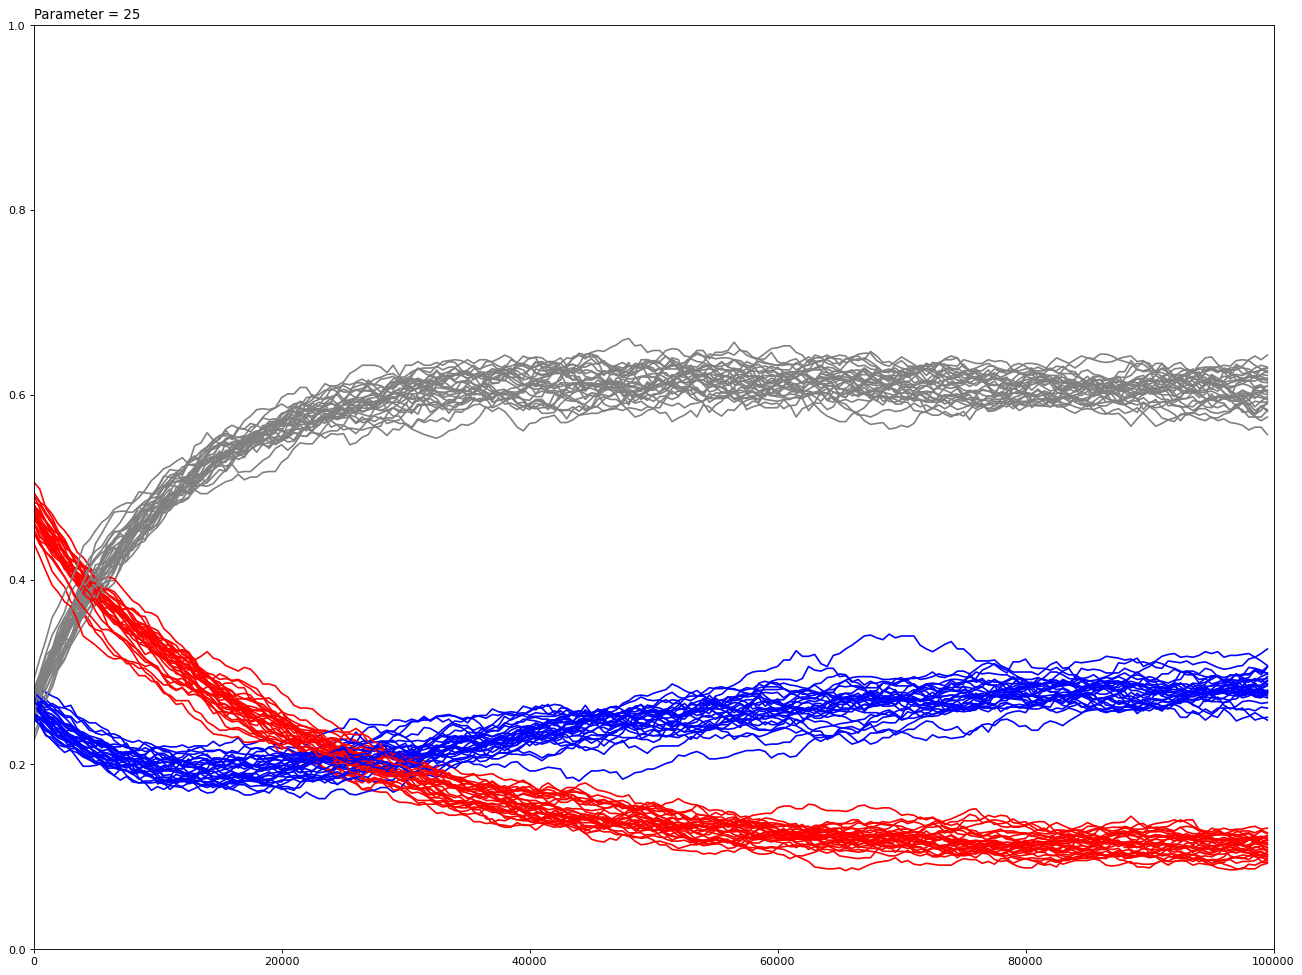

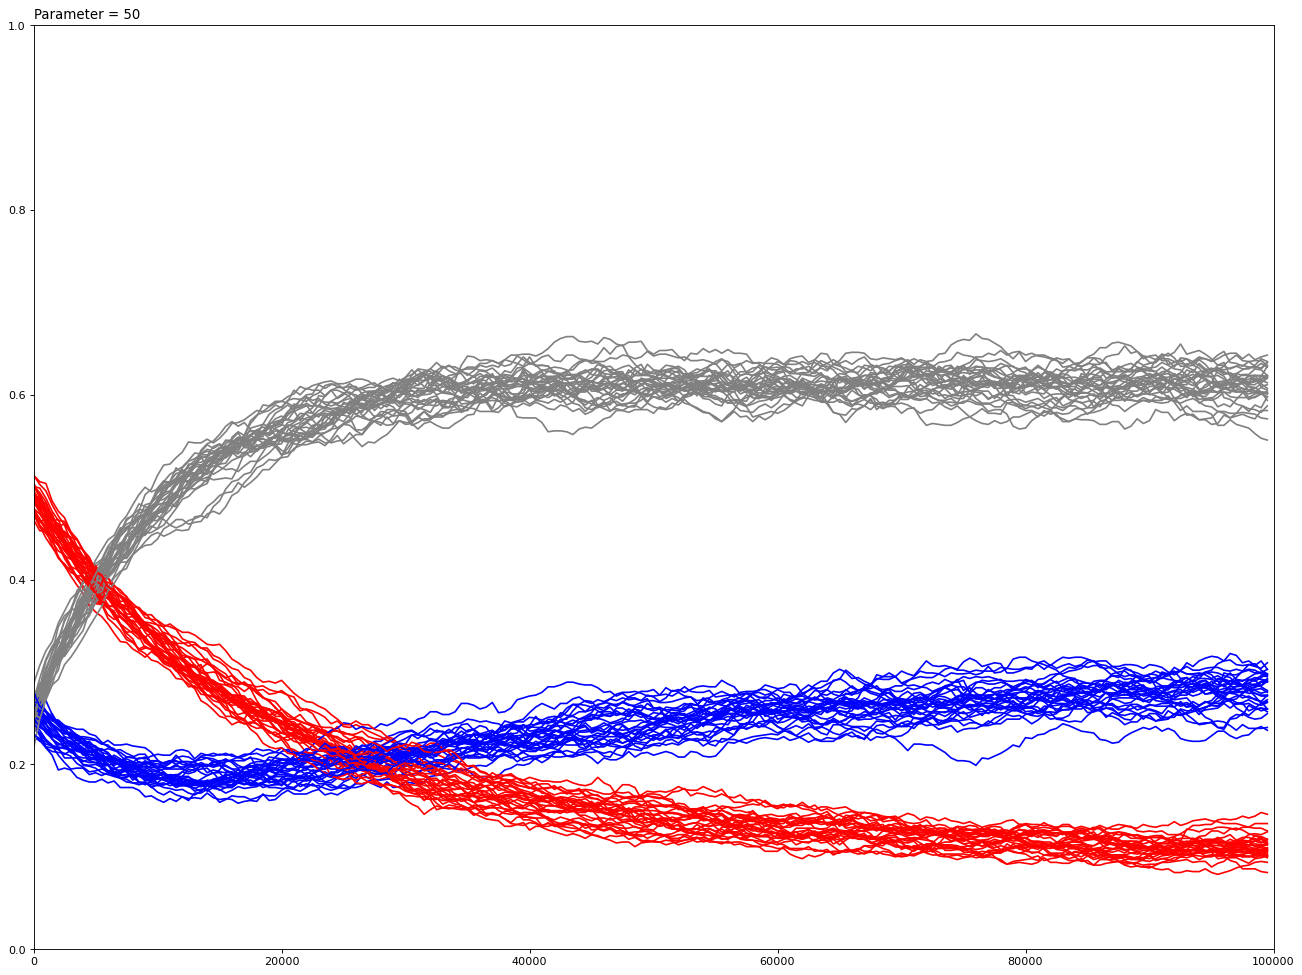

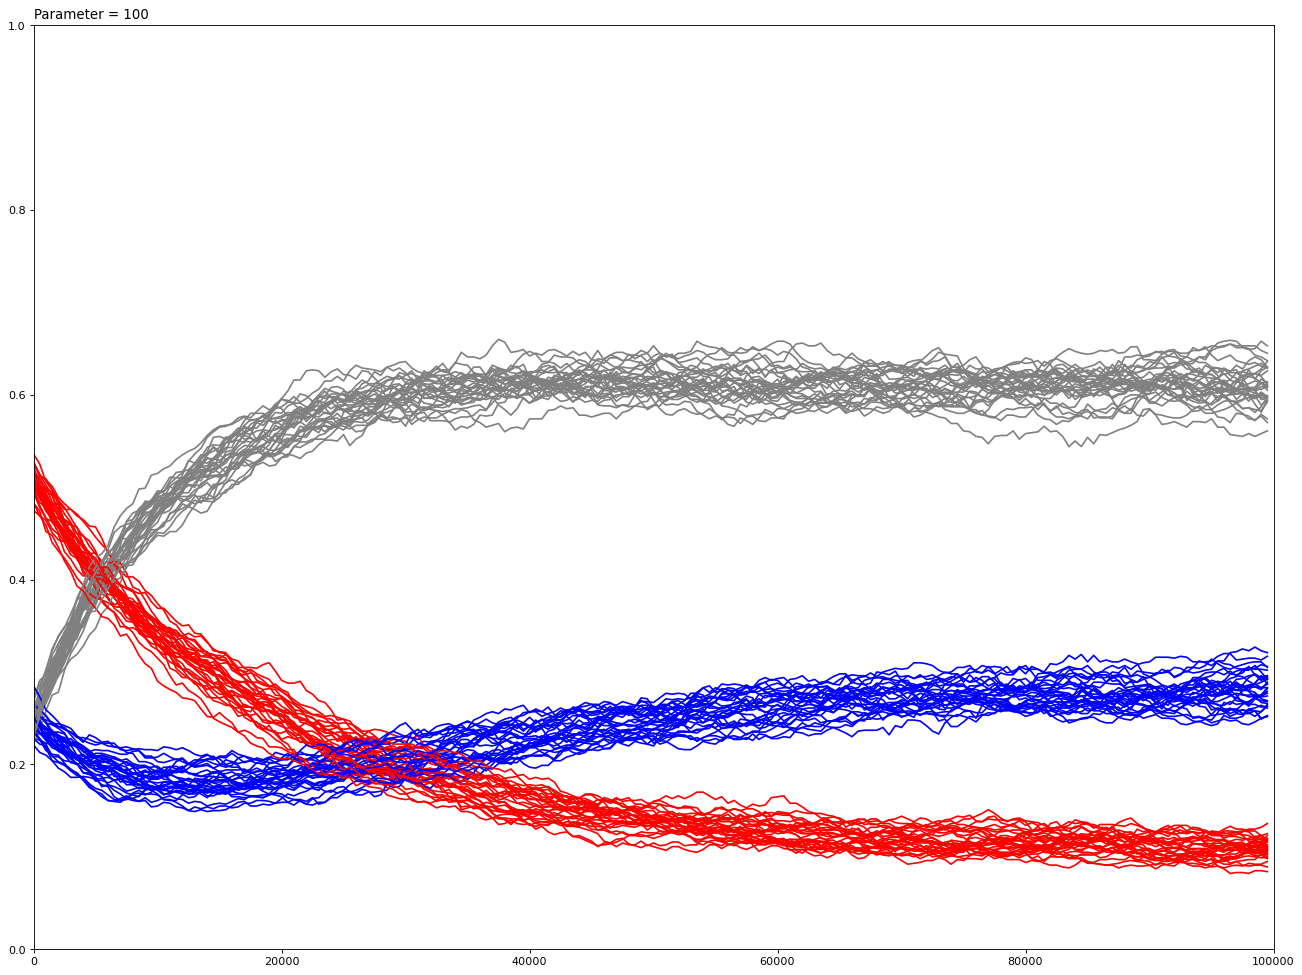

In [160]:
T = 100 * N

#for T in [10*N, 100*N]:
for param, marker in zip(params, markers):
    y_ts = []
    for run in range(series):
        hps_dict, run_dict = load_experiment("Barabasi-Albert : N = 1000, d = 3, m = 3 (v2)", param=param, run_number=run)

        Y_run = np.array(run_dict["Y distribution"])

        y_ts.append(Y_run / N)

    plt.figure(figsize=(20, 15), dpi=80)
    plt.axis([0.0, T + 1, 0.0, 1.0])

    x = np.arange(T + 1)[1::500]
    for run in range(series):
        for o, color in zip(range(m), ['blue', 'grey', 'red']):
            y = np.array(y_ts[run])[:, o][1::500] #every 500th
            plt.plot(x, y, c=color)

    plt.title("Parameter = {}".format(param), loc = 'left')
    plt.show()

#### Barabasi-Albert : N = 1000, d = 3, m = 3 (v2)

In [198]:
hps_dict, _ = load_experiment("Barabasi-Albert : N = 1000, d = 3, m = 3 (v2)", param=1, run_number=0)
N = hps_dict["graph_params"]["N"]
m = hps_dict["opinions"]
params = hps_dict["param values"]
series = hps_dict["number of runs"]

print(params)

[1, 5, 10, 50, 100, 1000]


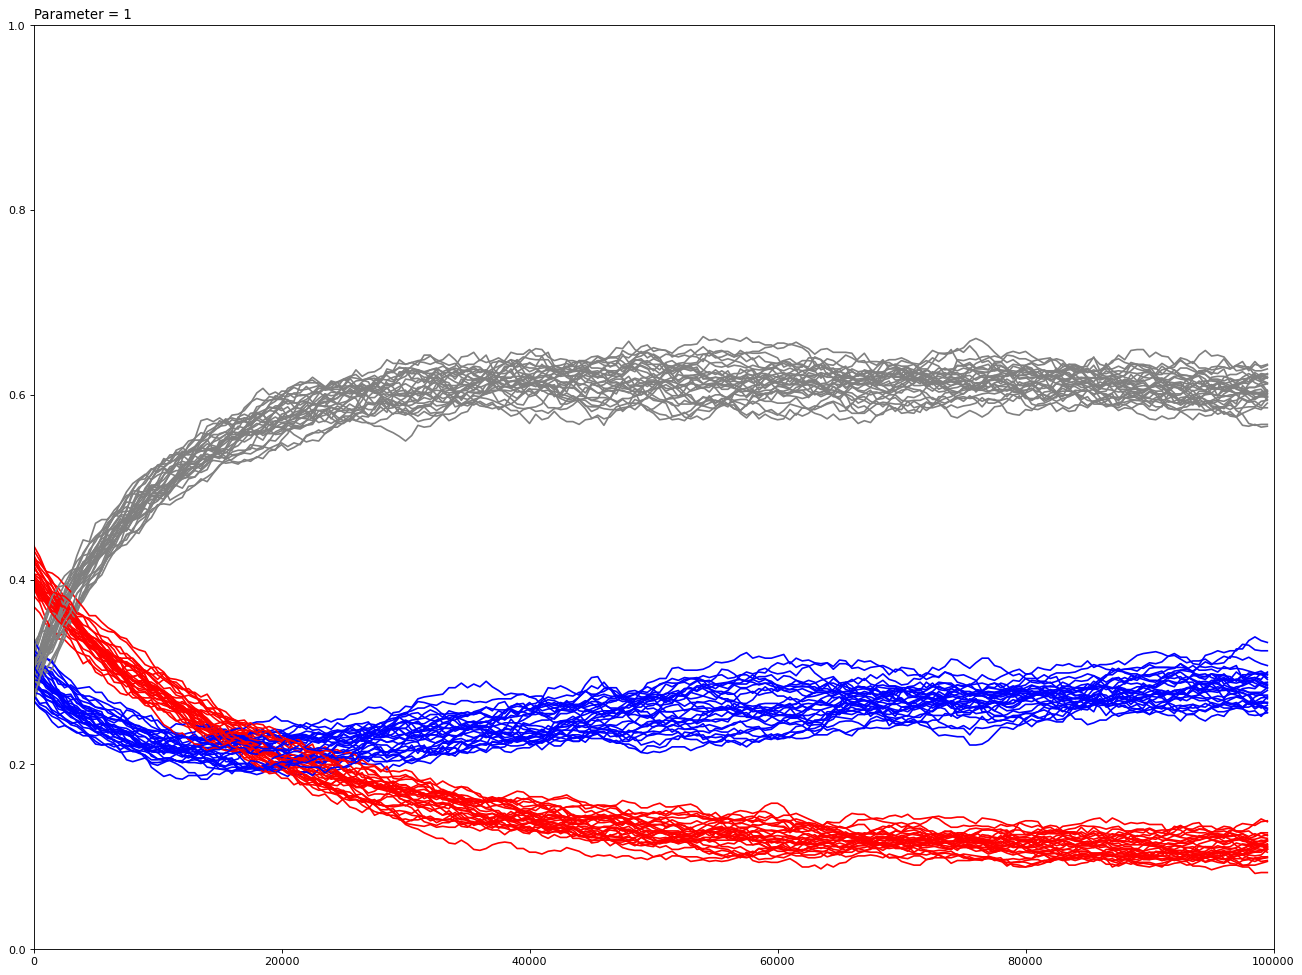

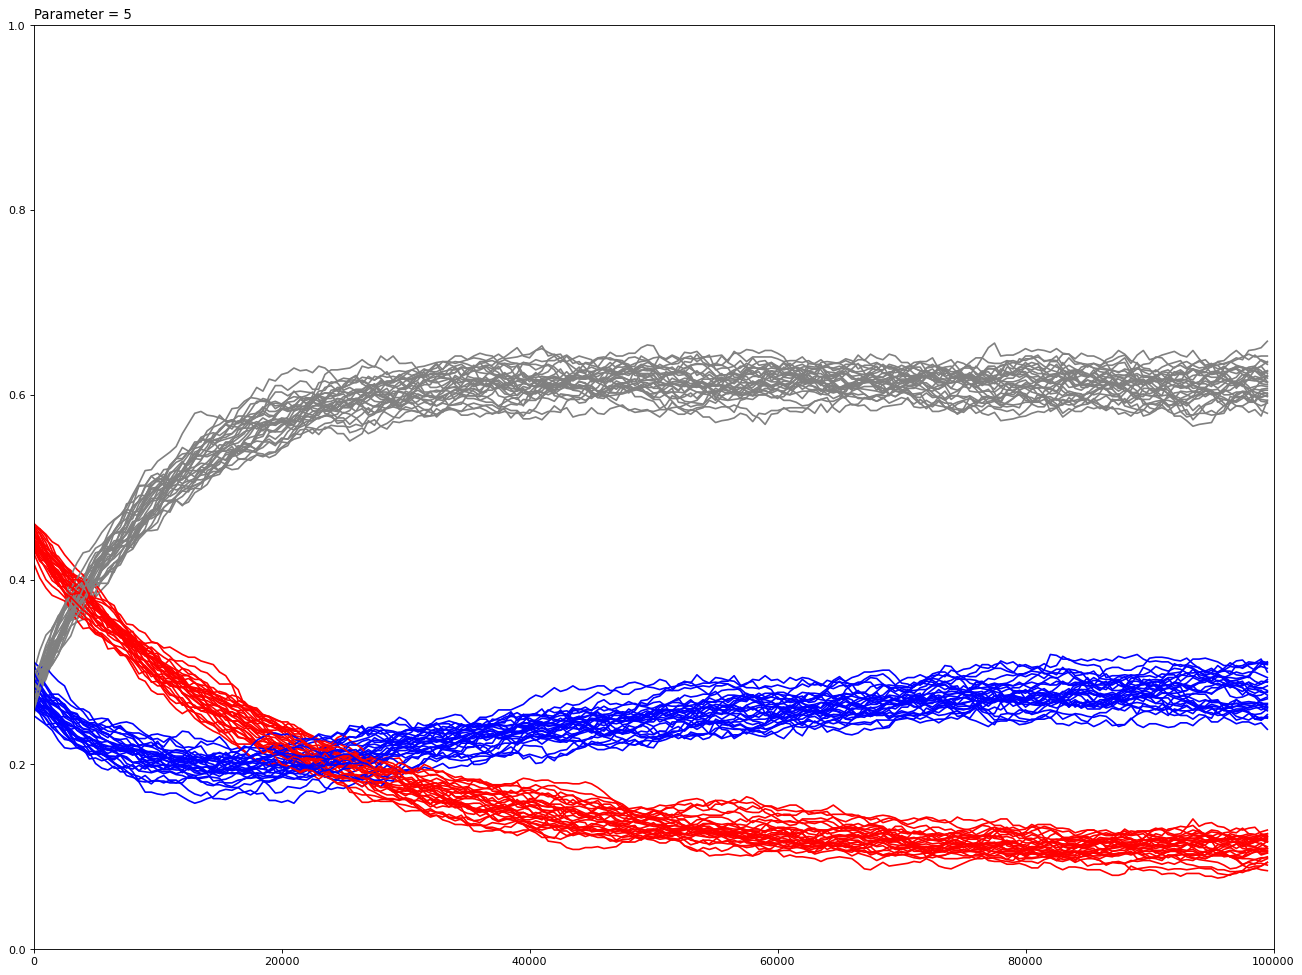

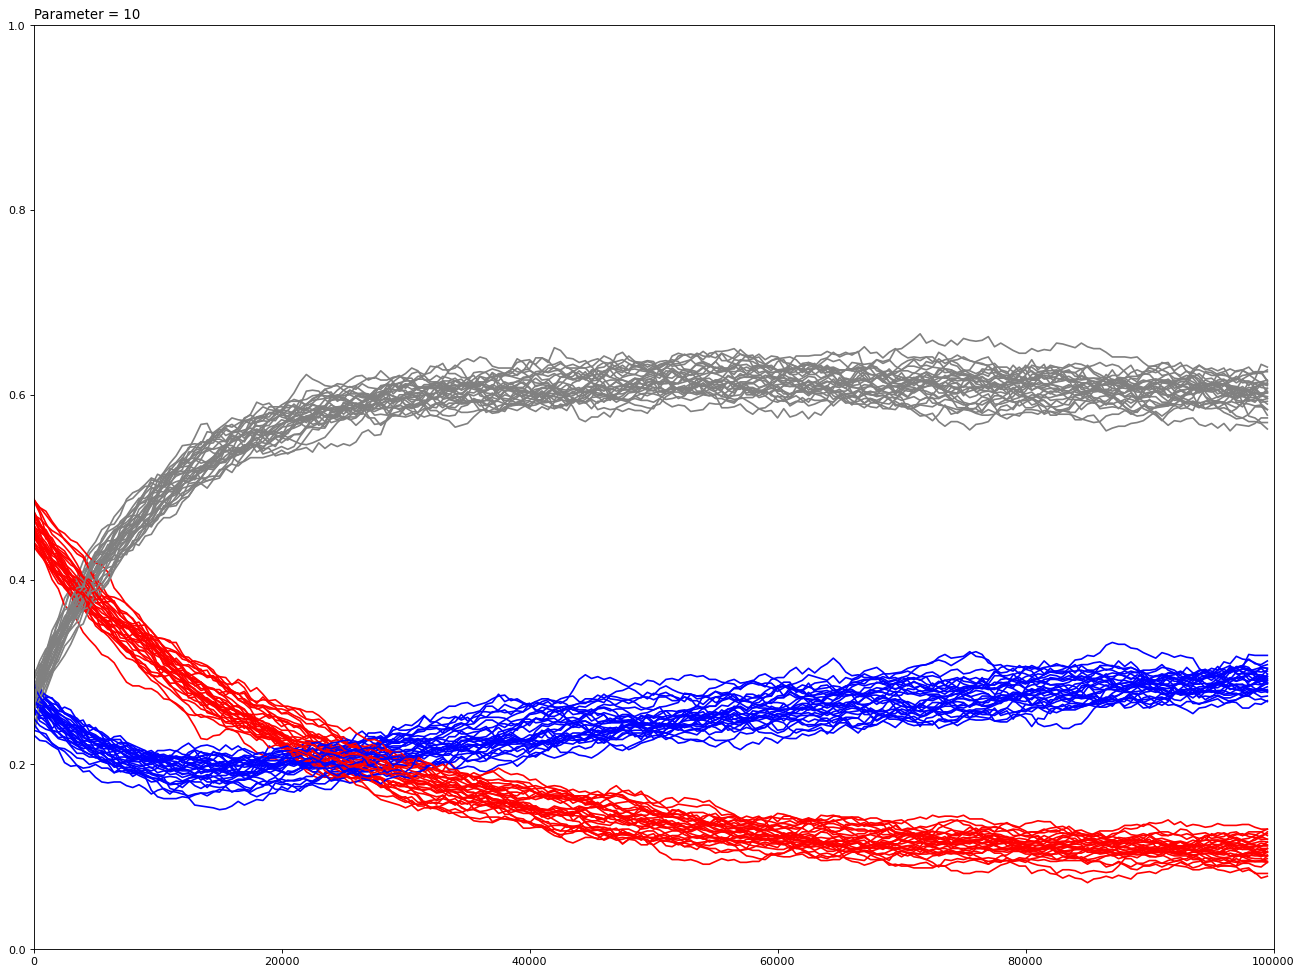

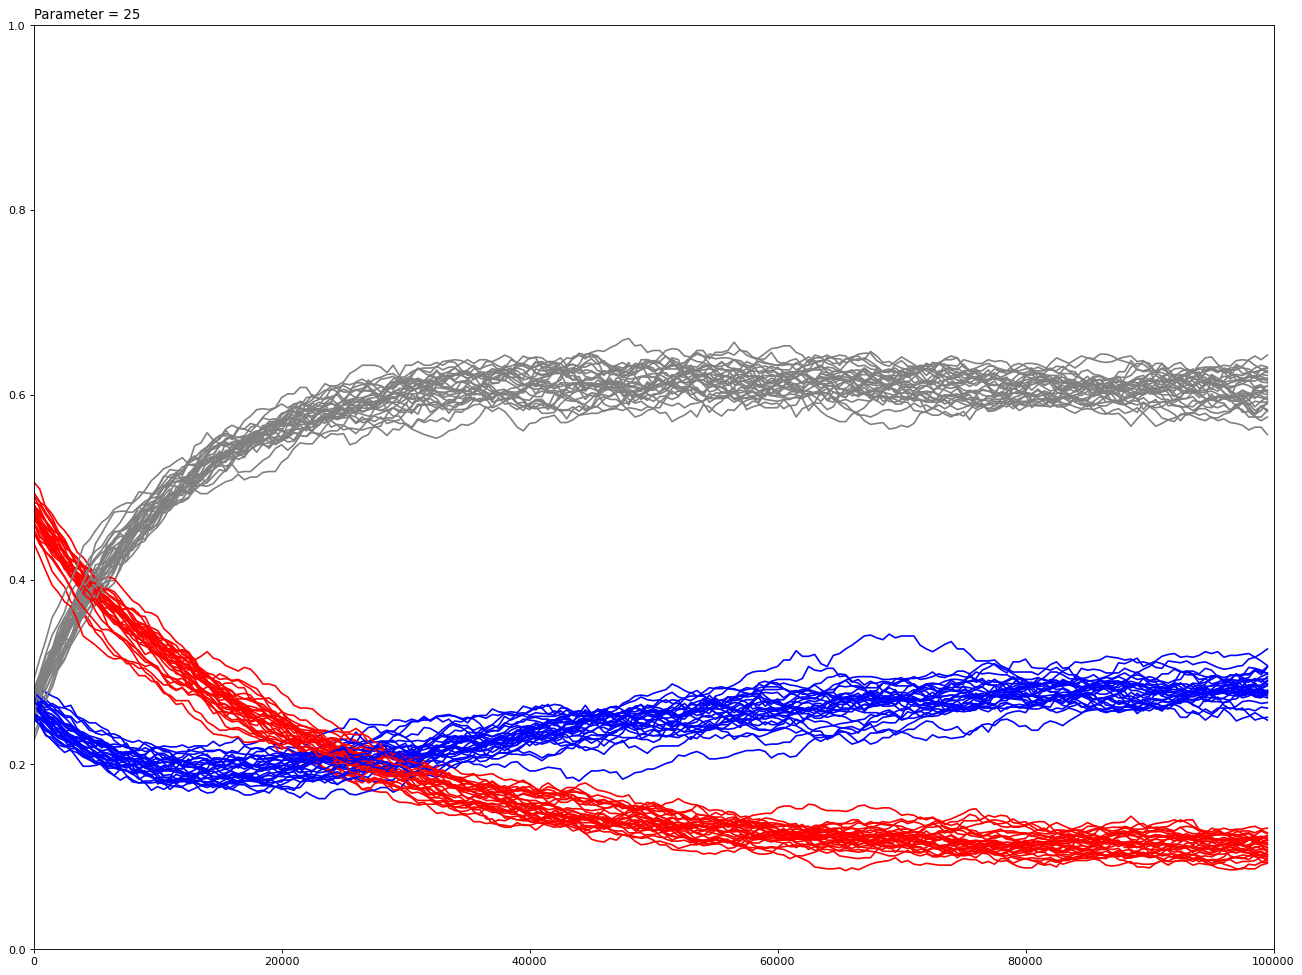

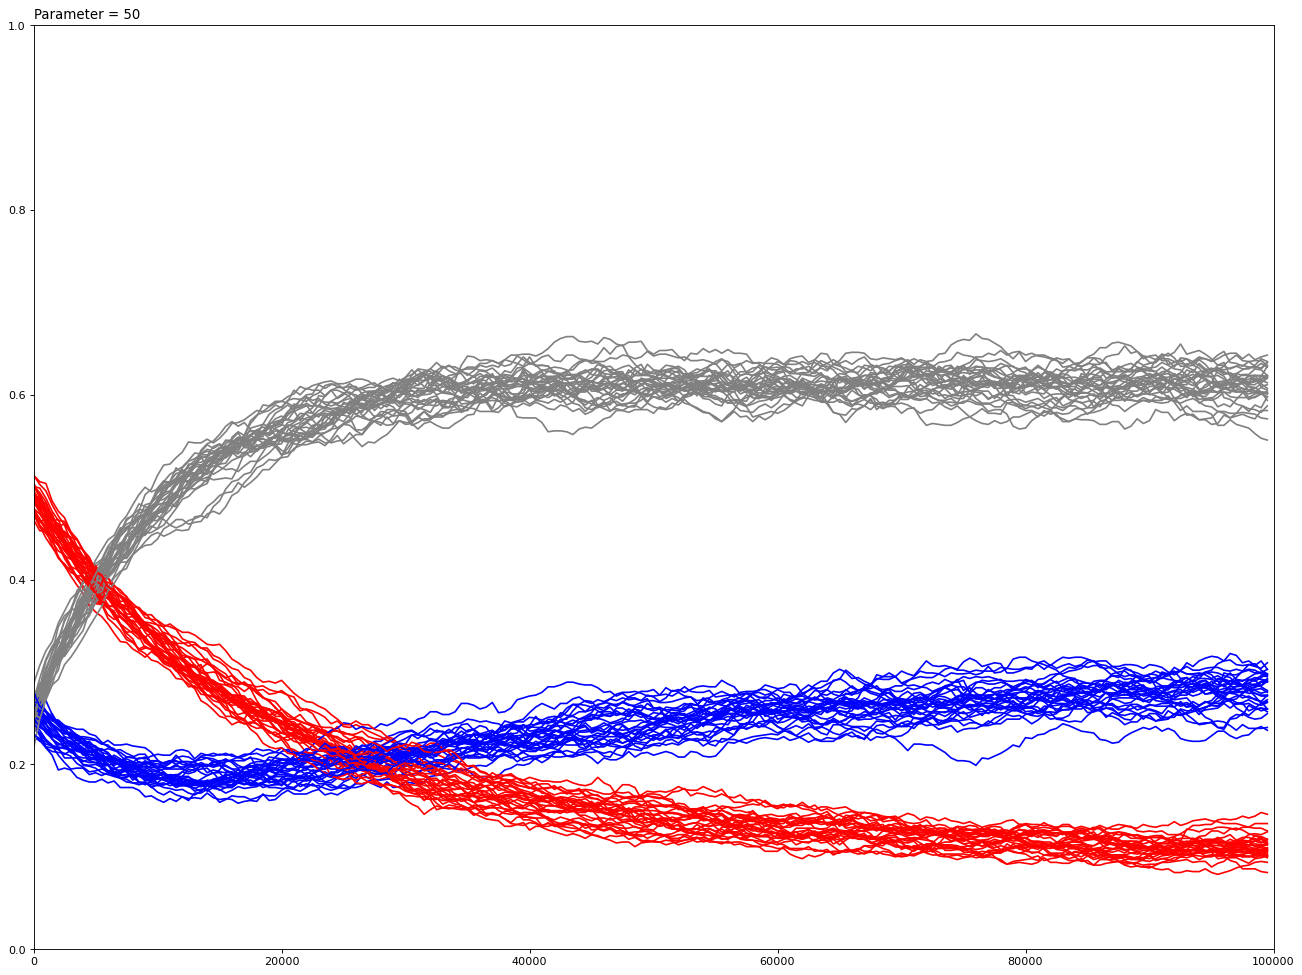

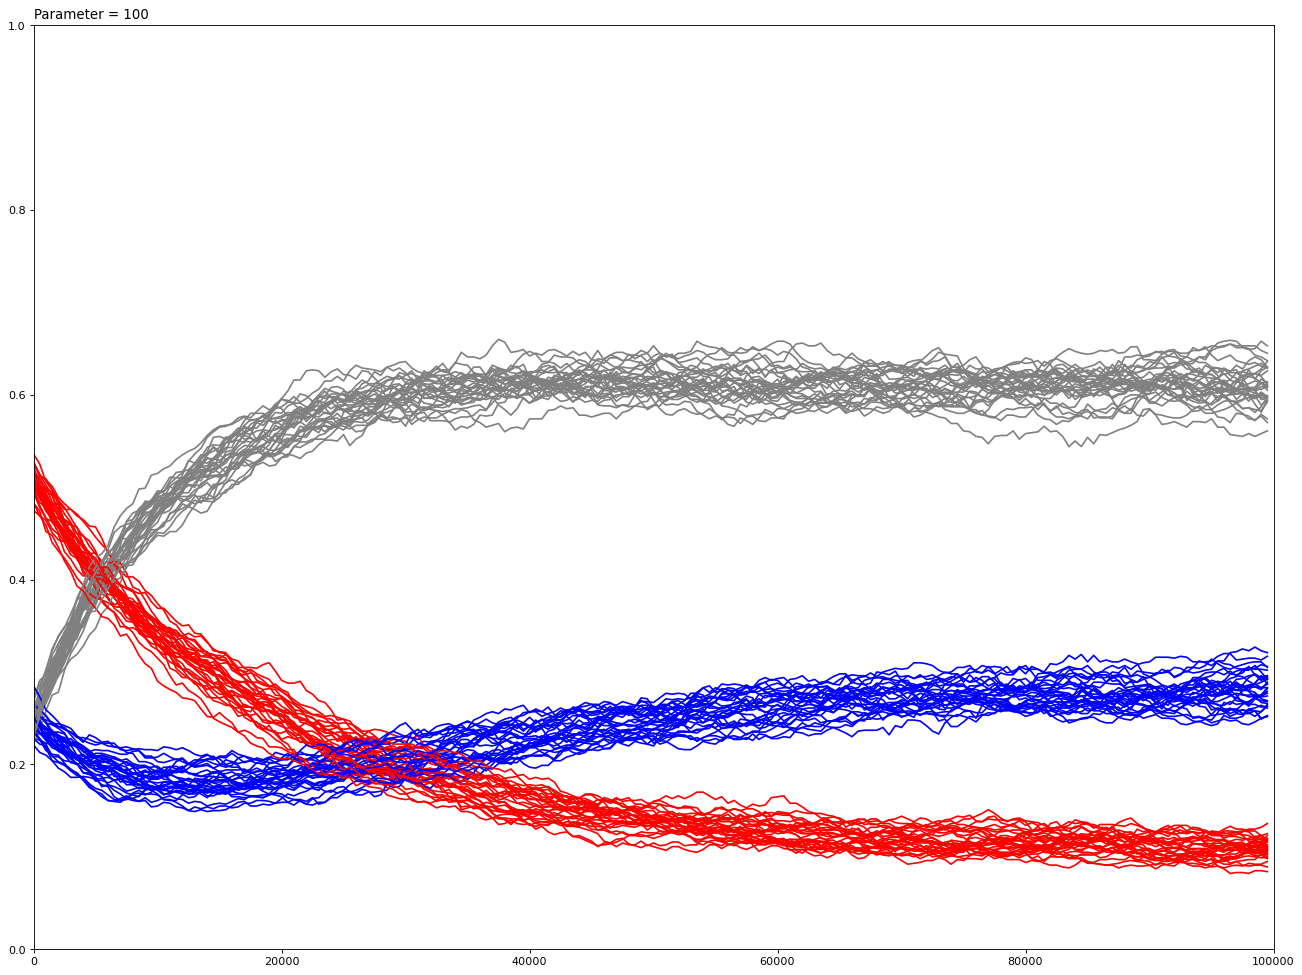

In [ ]:
T = 100 * N

#for T in [10*N, 100*N]:
for param, marker in zip(params, markers):
    y_ts = []
    for run in range(series):
        hps_dict, run_dict = load_experiment("Barabasi-Albert : N = 1000, d = 3, m = 3 (v2)", param=param, run_number=run)

        Y_run = np.array(run_dict["Y distribution"])

        y_ts.append(Y_run / N)

    plt.figure(figsize=(20, 15), dpi=80)
    plt.axis([0.0, T + 1, 0.0, 1.0])

    x = np.arange(T + 1)[1::500]
    for run in range(series):
        for o, color in zip(range(m), ['blue', 'grey', 'red']):
            y = np.array(y_ts[run])[:, o][1::500] #every 500th
            plt.plot(x, y, c=color)

    plt.title("Parameter = {}".format(param), loc = 'left')
    plt.show()

### Analyse centrality in initial opinions

In [199]:
exp_name = "Barabasi-Albert : N = 1000, d = 3, m = 3 (v2)"
hps_dict, _ = load_experiment(exp_name, param=1, run_number=0)

N = hps_dict["graph_params"]["N"]
m = hps_dict["opinions"]
params = hps_dict["param values"]
series = hps_dict["number of runs"]

print(params)

[1, 5, 10, 50, 100, 1000]


In [200]:
cumul_centrality = []

for param in params:
    param_sums = []
    for run in range(series):
        _, run_dict = load_experiment(exp_name, param=param, run_number=run)
        init_ops = run_dict["inintial opinions"]

        G = sparse.load_npz("./" + exp_name + "/param=" + str(param) + "/" + exp_name + " " + str(param) + " " + str(run) + ".npz")
        #np.array(run_dict["Y distribution"])

        opinions_sum = {} 
        # for each opinion
        for opinion in range(m):
            opinion_degree_sum = 0
            for agent in [ind for ind, o in enumerate(init_ops) if o == opinion]:
                opinion_degree_sum += len(G.indices[G.indptr[agent]:G.indptr[agent + 1]])
            opinions_sum[opinion] = opinion_degree_sum
        param_sums.append(opinions_sum)

    cumul_centrality.append(param_sums)

print(params)
print(cumul_centrality)

[1, 5, 10, 50, 100, 1000]
[[{0: 1346, 1: 1247, 2: 3389}, {0: 1385, 1: 1255, 2: 3342}, {0: 1245, 1: 1364, 2: 3373}, {0: 1315, 1: 1288, 2: 3379}, {0: 1388, 1: 1238, 2: 3356}, {0: 1356, 1: 1339, 2: 3287}, {0: 1219, 1: 1397, 2: 3366}, {0: 1197, 1: 1455, 2: 3330}, {0: 1367, 1: 1236, 2: 3379}, {0: 1331, 1: 1232, 2: 3419}, {0: 1315, 1: 1398, 2: 3269}, {0: 1307, 1: 1354, 2: 3321}, {0: 1231, 1: 1277, 2: 3474}, {0: 1294, 1: 1472, 2: 3216}, {0: 1290, 1: 1383, 2: 3309}, {0: 1436, 1: 1313, 2: 3233}, {0: 1130, 1: 1382, 2: 3470}, {0: 1334, 1: 1400, 2: 3248}, {0: 1361, 1: 1330, 2: 3291}, {0: 1245, 1: 1338, 2: 3399}, {0: 1456, 1: 1221, 2: 3305}, {0: 1318, 1: 1404, 2: 3260}, {0: 1334, 1: 1245, 2: 3403}, {0: 1343, 1: 1294, 2: 3345}, {0: 1231, 1: 1246, 2: 3505}, {0: 1310, 1: 1317, 2: 3355}, {0: 1422, 1: 1219, 2: 3341}, {0: 1310, 1: 1162, 2: 3510}, {0: 1570, 1: 1200, 2: 3212}, {0: 1261, 1: 1387, 2: 3334}], [{0: 1208, 1: 1142, 2: 3632}, {0: 1105, 1: 1175, 2: 3702}, {0: 1181, 1: 1109, 2: 3692}, {0: 1184, 1: 

Summarized init opinion node gedrees 

### Convergence ?

In [33]:
#del cache
gc.collect()

67444

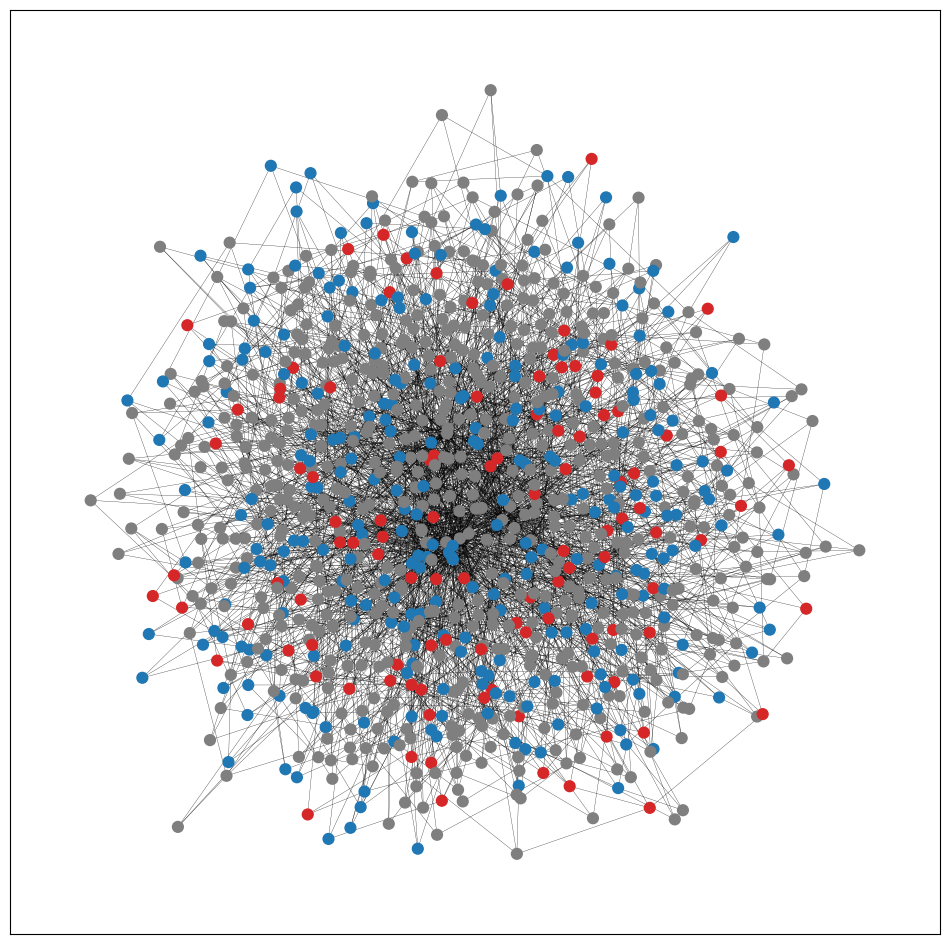

100%|██████████| 100000/100000 [00:07<00:00, 12999.26it/s]


In [69]:
run_and_save_experiment("test init degree centrality opinions", Gr, G, m, P, 1, 2, True, N=N, d=d, seed=seed)

100%|██████████| 50000/50000 [08:59<00:00, 92.62it/s] 
/tmp/ipykernel_20991/792862047.py:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


NameError: name 'os' is not defined

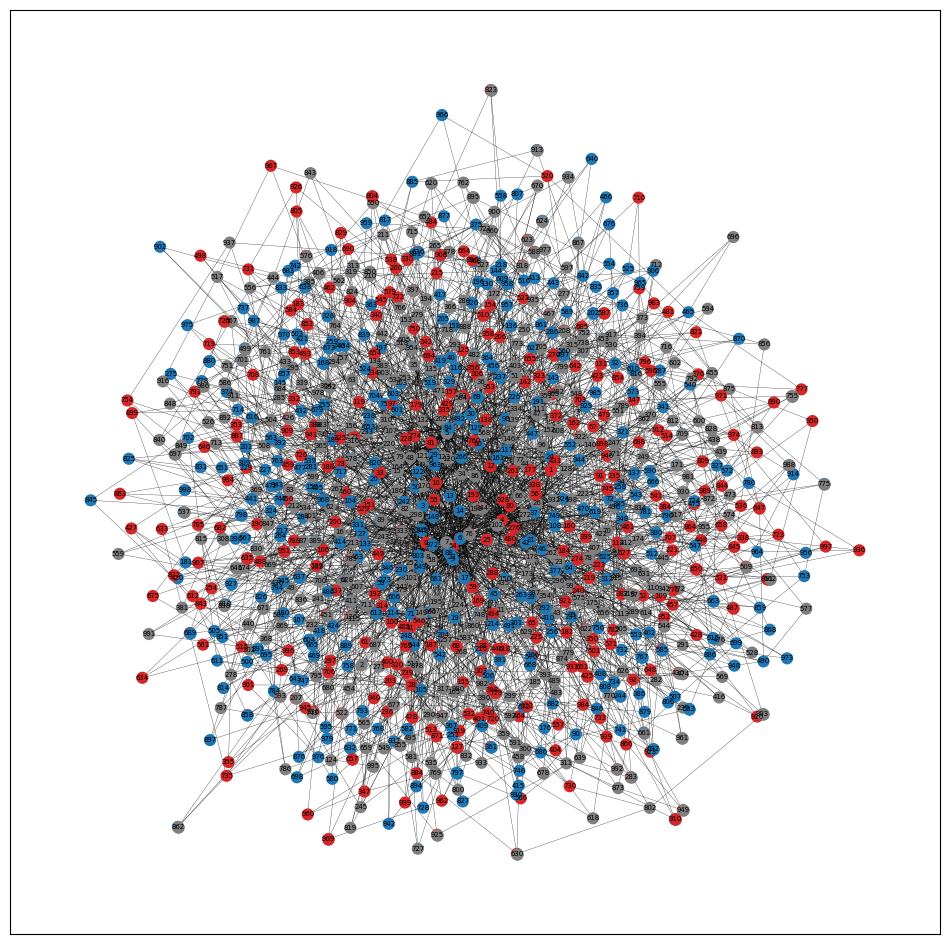

In [30]:
node_colors = ["tab:blue" if opinion==0 else "tab:grey" if opinion==1 else "tab:red" for opinion in o[0]]
plt.figure(figsize=(12,12))
nx.draw_networkx(Gr, node_size=60, node_color=node_colors, font_size=5, width=0.2, pos=pos)

ax = plt.gca()
"""
for infl in infls_test[:1]:
    new_node_color = "tab:blue" if infl[4]==0 else "tab:grey" if infl[4]==1 else "tab:red"
    ax.add_collection(nx.draw_networkx_nodes(Gr, nodelist=[infl[0]], node_size=60, node_color=new_node_color, pos=pos))
plt.show()
"""

filenames = []
i=0

for t in tqdm(range(len(infls_test[:50000]))):
    infl = infls_test[t]
    if infl[1] != infl[4]:
        i+=1
        if i % 10 == 0:
            new_node_color = "tab:blue" if infl[4]==0 else "tab:grey" if infl[4]==1 else "tab:red"
            ax.add_collection(nx.draw_networkx_nodes(Gr, nodelist=[infl[0]], node_size=60, node_color=new_node_color, pos=pos))
            
            # create file name and append it to a list
            filename = f'{i}.png'
            filenames.append(filename)
            
            # save frame
            plt.savefig(filename)
    
# build gif
with imageio.get_writer('test.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

In [20]:
o_test[10:], Y_test[10:], o_test[:-10], Y_test[:-10]

(array([[1, 0, 2, ..., 2, 1, 0],
        [1, 0, 2, ..., 2, 1, 0],
        [1, 0, 2, ..., 2, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 1],
        [1, 0, 0, ..., 0, 1, 1],
        [1, 0, 0, ..., 0, 1, 1]]),
 array([[345, 340, 315],
        [345, 341, 314],
        [345, 341, 314],
        ...,
        [339, 605,  56],
        [339, 605,  56],
        [339, 605,  56]]),
 array([[1, 0, 2, ..., 2, 1, 0],
        [1, 0, 2, ..., 2, 1, 0],
        [1, 0, 2, ..., 2, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 1],
        [1, 0, 0, ..., 0, 1, 1],
        [1, 0, 0, ..., 0, 1, 1]]),
 array([[346, 339, 315],
        [346, 339, 315],
        [346, 339, 315],
        ...,
        [339, 605,  56],
        [339, 605,  56],
        [339, 605,  56]]))

In [95]:
print(len(infls_test))
print(infls_test[:10])

500000
[(829, 2, 246, 2, 2), (297, 0, 486, 2, 0), (556, 1, 576, 2, 1), (188, 1, 328, 0, 1), (479, 2, 594, 1, 2), (224, 0, 836, 1, 0), (356, 2, 7, 1, 2), (744, 0, 13, 1, 0), (496, 0, 253, 2, 0), (422, 2, 3, 1, 2)]


In [96]:
y_test = Y_test / N
y_test[:10]

array([[0.321, 0.353, 0.326],
       [0.321, 0.353, 0.326],
       [0.321, 0.353, 0.326],
       [0.321, 0.353, 0.326],
       [0.321, 0.353, 0.326],
       [0.321, 0.353, 0.326],
       [0.321, 0.353, 0.326],
       [0.321, 0.353, 0.326],
       [0.321, 0.353, 0.326],
       [0.321, 0.353, 0.326]])

In [97]:
print(np.sum(y_test, axis=1)[:100])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


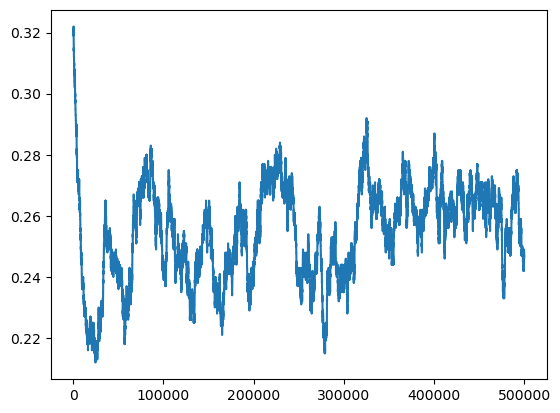

In [98]:
plt.plot(y_test[:, 0])

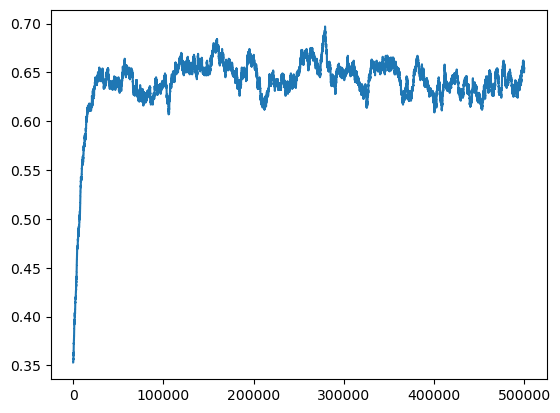

In [99]:
plt.plot(y_test[:, 1])

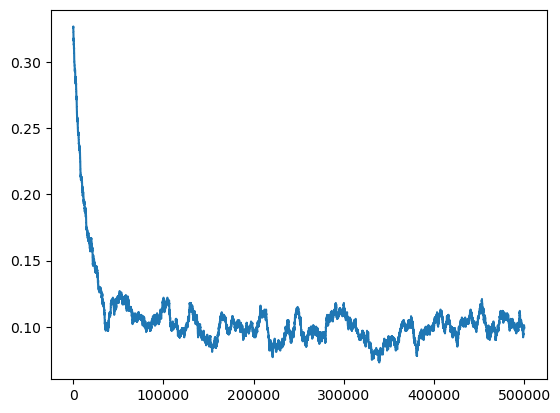

In [100]:
plt.plot(y_test[:, 2])